R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Selection.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

## Model selection

In a given regression situation, there are often many choices to
be made. Recall our usual setup
$$
Y_{n \times 1} = X_{n \times p} \beta_{p \times 1} + \epsilon_{n \times 1}.
$$

Any *subset $A \subset \{1, \dots, p\}$* yields a new regression model
$$
{\cal M}(A): Y_{n \times 1} = X[,A] \beta[A] + \epsilon_{n \times 1}
$$
by setting $\beta[A^c]=0$.

**Model selection** is, roughly speaking, how to choose $A$ among the
$2^p$ possible choices.

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score


In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'

### Election data

Here is a dataset from the book that we will use to explore different model selection approaches.

Variable | Description
--- | ---
$V$ | votes for a presidential candidate
$I$ | are they incumbent?
$D$ | Democrat or Republican incumbent?
$W$ | wartime election?
$G$ | GDP growth rate in election year
$P$ | (absolute) GDP deflator growth rate
$N$ | number of quarters in which GDP growth rate $> 3.2\%$

In [4]:
url = 'http://stats191.stanford.edu/data/election.table'
election_data = pd.read_table(url)
election_data.head()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


,Year,V,I,D,W,G,P,N
0,1916,0.5168,1,1,0,2.229,4.252,3
1,1920,0.3612,1,0,1,-11.463,16.535,5
2,1924,0.4176,-1,-1,0,-3.872,5.161,10
3,1928,0.4118,-1,0,0,4.623,0.183,7
4,1932,0.5916,-1,-1,0,-14.901,7.069,4


In [5]:
# sns.pairplot(election_data)
# plt.show()

## Problem & Goals

* When we have many predictors (with many possible interactions), it can be difficult to find a good model.
* Which main effects do we include?
* Which interactions do we include?
* Model selection procedures try to *simplify / automate* this task.
* Election data has $2^6=64$ different models with just main effects!

## General comments

- This is generally an "unsolved" problem in statistics: there are no magic procedures to get you the "best model."

- Many machine learning methods look for good "sparse" models: selecting a "sparse" model.

- "Machine learning" often work with very many predictors.

- Our model selection problem is generally at a much smaller scale than "data mining" problems.

- Still, it is a hard problem.

- **Inference after selection is full of pitfalls!** 



## Hypothetical example
* Suppose we fit a a model $F: \quad Y_{n \times 1} = X_{n \times p} \beta_{p \times 1} + \varepsilon_{n \times 1}$ with predictors ${ X}_1, \dots, { X}_p$.
* In reality, some of the $\beta$s may be zero. Let's suppose that $\beta_{j+1}= \dots= \beta_{p}=0$.
* Then, any model that includes $\beta_0, \dots, \beta_j$ is *correct*: which model gives the *best* estimates of $\beta_0, \dots, \beta_j$?
* Principle of *parsimony* (i.e. Occam's razor) says that the model with *only* ${X}_1, \dots, {X}_j$ is "best".

## Justifying parsimony

- For simplicity, let's assume that $j=1$ so there is only one coefficient to estimate.
- Then, because each model gives an *unbiased* estimate of $\beta_1$ we can compare models based on $\text{Var}(\widehat{\beta}_1).$
- The best model, in terms of this variance, is the one containing only ${ X}_1$.
- What if we didn't know that only $\beta_1$ was non-zero (which we don't know in general)?
- In this situation, we must choose a set of variables.

## Model selection: choosing a subset of variables

* To "implement" a model selection procedure, we first need a criterion or benchmark to compare two models.
* Given a criterion, we also need a search strategy.
* With a limited number of predictors, it is possible to search all possible models (`leaps` in `R`).

## Candidate criteria

Possible criteria:

* $R^2$: not a good criterion. Always increase with model size $\implies$ "optimum" is to take the biggest model.
* Adjusted $R^2$: better. It "penalized" bigger models. Follows principle of parsimony / Occam's razor.
* Mallow's $C_p$ - attempts to estimate a model's predictive power, i.e. the power to predict a new observation.

### Best subsets, $R^2$

Leaps takes a design matrix as argument: throw away the intercept
column or leaps will complain.


In [6]:
# R leaps: Regression subset selection, including exhaustive search
# Source: https://cran.r-project.org/web/packages/leaps/leaps.pdf

In [7]:
election_data.head()

,Year,V,I,D,W,G,P,N
0,1916,0.5168,1,1,0,2.229,4.252,3
1,1920,0.3612,1,0,1,-11.463,16.535,5
2,1924,0.4176,-1,-1,0,-3.872,5.161,10
3,1928,0.4118,-1,0,0,4.623,0.183,7
4,1932,0.5916,-1,-1,0,-14.901,7.069,4


In [8]:
election_data.columns

Index(['Year  ', 'V  ', 'I  ', 'D  ', 'W  ', 'G  ', 'P  ', 'N  '], dtype='object')

In [9]:
election_data.rename(columns={"Year  ":"Year",
                               "V  ":"V",
                               "I  ":"I",
                               "D  ":"D",
                               "W  ":"W",
                               "G  ":"G",
                               "P  ":"P",
                               "N  ":"N" 
                               }, inplace=True)
election_data.columns

Index(['Year', 'V', 'I', 'D', 'W', 'G', 'P', 'N'], dtype='object')

In [10]:
election_res = ols('V ~ I + D + W + G:I + P + N', data=election_data).fit()
election_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      V   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     8.769
Date:                Mon, 01 Jul 2019   Prob (F-statistic):           0.000435
Time:                        21:49:23   Log-Likelihood:                 41.470
No. Observations:                  21   AIC:                            -68.94
Df Residuals:                      14   BIC:                            -61.63
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5112      0.032     15.875      0.000       0.442       0.580
I             -0.0201      0.017     -1.190      0.254      -0.056       0.016
D              0.0546      0.021      2.655      0.019       0.010       0.099
W              0.0134      0.042      0.317      0.756      -0.077       0.104
G:I            0.0097      0.002      5.471      0.000       0.006       0.013
P             -0.0007      0.004     -0.180      0.859      -0.009       0.008
N             -0.0052      0.004     -1.361      0.195      -0.013       0.003
==============================================================================
Omnibus:                        6.714   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                4.488
Skew:                           1.074   Prob(JB):                        0.106
Kurtosis:                       3.719   Cond. No.                         43.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Could not find the Python equivalent to R package, "leaps"  

Source: https://stackoverflow.com/questions/37624920/subset-regression-in-python-via-exhaustive-search  
Source: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

In [11]:
election_res.model.exog_names.remove("Intercept")

In [12]:
election_res.model.exog_names

['I', 'D', 'W', 'G:I', 'P', 'N']

**This is not equivalent to R leaps**

In [13]:
# This is not equivalent to R leaps
from itertools import combinations
scores_lst=[]
for r in range(1, len(election_res.model.exog_names)+1):
    comb = combinations(election_res.model.exog_names, r = r)
    for item in comb:
        formula = 'V ~ {}'.format('+'.join(set(item)))
        
        # method='r2' in the R notebook
        score = ols(formula, election_data).fit().rsquared
        scores_lst.append((len(item)+1, formula, score))

In [14]:
scores_df = pd.DataFrame(scores_lst, columns=["size","formula","score"])
scores_df.head(10)

,size,formula,score
0,2,V ~ I,0.120047
1,2,V ~ D,0.249171
2,2,V ~ W,0.008446
3,2,V ~ G:I,0.612163
4,2,V ~ P,0.110441
5,2,V ~ N,0.021514
6,3,V ~ I+D,0.260595
7,3,V ~ I+W,0.180652
8,3,V ~ I+G:I,0.648134
9,3,V ~ I+P,0.261660


Let's plot the $R^2$ as a function of the model size. We see that the
full model does include all variables. 

In [15]:
scores_df_grpd = scores_df.groupby("size").max()
scores_df_grpd

,formula,score
size,,
2,V ~ W,0.612163
3,V ~ W+D,0.734504
4,V ~ W+G:I+D,0.765193
5,V ~ W+G:I+D+P,0.788278
6,V ~ W+P+D+I+G:I,0.789340
7,V ~ W+N+P+D+I+G:I,0.789828


In [16]:
def plotting_size_vs_score(x, y, annotate=False, 
                           xlabel='size', ylabel='r2', 
                           ymin=0, ymax=0.85):
    plt.scatter(x, y)
    
    if annotate == True:
        labels = ['{}'.format(round(i, 3)) for i in y]
        for label, x, y in zip(labels, x, y):
            plt.annotate(label, xy=(x, y), alpha=0.5)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ymin, ymax)
    plt.show()

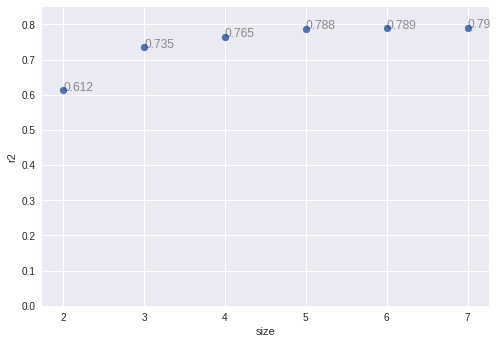

In [17]:
plotting_size_vs_score(scores_df_grpd.index, 
                       scores_df_grpd["score"], 
                       annotate=True)

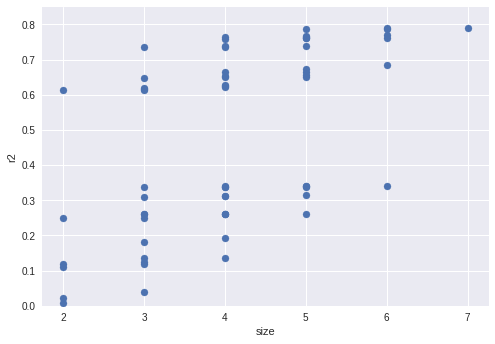

In [18]:
plotting_size_vs_score(scores_df["size"], 
                       scores_df["score"], 
                       annotate=False)

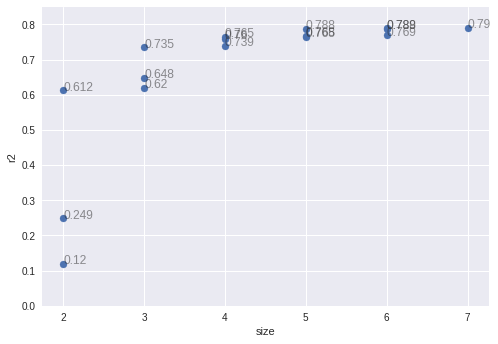

In [19]:
# best 3
best_r2_lst=[]
for i, group in scores_df.groupby("size"):
    best_df = group.sort_values("score", ascending=False)
    best_r2_lst.append(best_df.iloc[:3,:])

# plot them
choose_best_r2_df = pd.concat(best_r2_lst)
plotting_size_vs_score(choose_best_r2_df["size"], 
                       choose_best_r2_df["score"], 
                       annotate=True,
                       ymin=0,
                       ymax=0.85)

**This is not equivalent to R leaps**

## Best subsets, adjusted $R^2$

-   As we add more and more variables to the model - even random ones,
    $R^2$ will increase to 1.

-   Adjusted $R^2$ tries to take this into account by replacing sums of squares by *mean squares*
    $$R^2_a = 1 - \frac{SSE/(n-p-1)}{SST/(n-1)} = 1 - \frac{MSE}{MST}.$$


**This is not equivalent to R leaps**

In [20]:
# This is not equivalent to R leaps
scores_adj_lst=[]
for r in range(1, len(election_res.model.exog_names)+1):
    comb = combinations(election_res.model.exog_names, r = r)
    for item in comb:
        formula = 'V ~ {}'.format('+'.join(set(item)))
        
        # method='adjusted r2' in the R notebook
        score_adj = ols(formula, election_data).fit().rsquared_adj
        scores_adj_lst.append((len(item)+1, formula, score_adj))

In [21]:
scores_adj_df = pd.DataFrame(scores_adj_lst, columns=["size","formula","score_adj"])
scores_adj_df.head(10)

,size,formula,score_adj
0,2,V ~ I,0.073733
1,2,V ~ D,0.209653
2,2,V ~ W,-0.043742
3,2,V ~ G:I,0.591750
4,2,V ~ P,0.063622
5,2,V ~ N,-0.029985
6,3,V ~ I+D,0.178439
7,3,V ~ I+W,0.089613
8,3,V ~ I+G:I,0.609038
9,3,V ~ I+P,0.179622


In [22]:
scores_adj_df_grpd = scores_adj_df.groupby("size").max()
scores_adj_df_grpd

,formula,score_adj
size,,
2,V ~ W,0.591750
3,V ~ W+D,0.705005
4,V ~ W+G:I+D,0.723757
5,V ~ W+G:I+D+P,0.735347
6,V ~ W+P+D+I+G:I,0.719119
7,V ~ W+N+P+D+I+G:I,0.699755


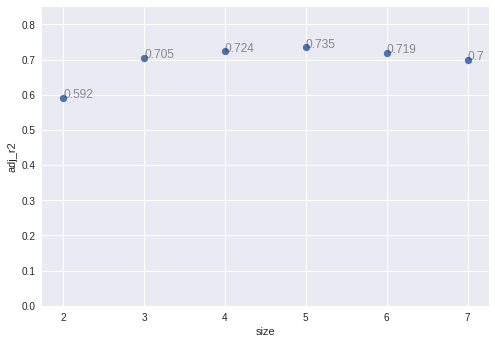

In [23]:
plotting_size_vs_score(scores_adj_df_grpd.index, 
                       scores_adj_df_grpd["score_adj"], 
                       annotate=True,
                       ylabel='adj_r2')

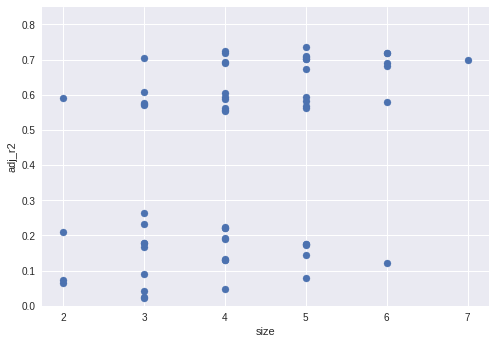

In [24]:
plotting_size_vs_score(scores_adj_df["size"], 
                       scores_adj_df["score_adj"], 
                       annotate=False,
                       ylabel='adj_r2')

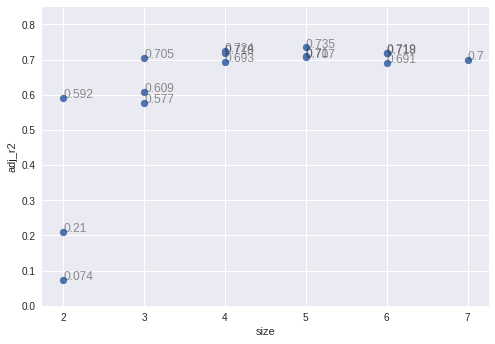

In [25]:
# best 3
best_adj_r2_lst=[]
for i, group in scores_adj_df.groupby("size"):
    best_adj_df = group.sort_values("score_adj", ascending=False)
    best_adj_r2_lst.append(best_adj_df.iloc[:3,:])

# plot them
choose_best_adj_r2_df = pd.concat(best_adj_r2_lst)
plotting_size_vs_score(choose_best_adj_r2_df["size"], 
                       choose_best_adj_r2_df["score_adj"], 
                       annotate=True,
                       ylabel='adj_r2',
                       ymin=0,
                       ymax=0.85)

In [26]:
# adjust R squared take account of the phenomenon of the R2 
# automatically and spuriously increasing when extra explanatory variables 
# are added to the model.
pd.concat([scores_df[scores_df["size"] == 7], 
           scores_adj_df[scores_adj_df["size"] == 7]],
         axis=1,
         sort=False)

,size,formula,score,size,formula,score_adj
62,7,V ~ W+N+P+D+I+G:I,0.789828,7,V ~ W+N+P+D+I+G:I,0.699755


In [27]:
pd.concat([scores_df[scores_df["size"] == 6], 
           scores_adj_df[scores_adj_df["size"] == 6]],
         axis=1,
         sort=False)

,size,formula,score,size,formula,score_adj
56,6,V ~ W+P+D+I+G:I,0.762030,6,V ~ W+P+D+I+G:I,0.682707
57,6,V ~ W+N+D+I+G:I,0.789340,6,V ~ W+N+D+I+G:I,0.719119
58,6,V ~ W+N+P+D+I,0.340481,6,V ~ W+N+P+D+I,0.120642
59,6,V ~ N+P+D+I+G:I,0.788321,6,V ~ N+P+D+I+G:I,0.717762
60,6,V ~ W+N+P+I+G:I,0.684002,6,V ~ W+N+P+I+G:I,0.578669
61,6,V ~ W+N+P+D+G:I,0.768571,6,V ~ W+N+P+D+G:I,0.691428


### Mallow's $C_p$

- $C_p({\cal M}) = \frac{SSE({\cal M})}{\widehat{\sigma}^2} + 2 \cdot p({\cal M}) - n.$
- $\widehat{\sigma}^2=SSE(F)/df_F$ is the "best" estimate of $\sigma^2$ we have (use the fullest model), i.e. in the election data it uses all 6 main effects.
- $SSE({\cal M})$ is the $SSE$ of the model ${\cal M}$.
- $p({\cal M})$ is the number of predictors in ${\cal M}$.
- This is an estimate of the expected mean-squared error of $\widehat{Y}({\cal M})$, it takes *bias* and *variance* into account.

If P regressors are selected from a set of K > P, the Cp statistic for that particular set of regressors is defined as:

C_p = (SSE_p/S2) - n + 2p

where:

    * SSE_k: the error sum of squares for the model with P regressors, where $y_pi$ is the predicted value of the ith observation of Y from the p regressors
    
$$
SSE_p = \sum_{i=1}^n (Y_i - Y_{pi})^2.
$$

    * S2: the residual mean square after regression on the complete set of K regressors and can be estimated by mean square error MSE
    
    * n: number of observations
    
    * p: number of subset explanatory variables
    
Source: https://en.wikipedia.org/wiki/Mallows%27s_Cp
Source: https://pypi.org/project/RegscorePy/

**This is not equivalent to R leaps**

In [28]:
# heavily borrowed from the Source: https://pypi.org/project/RegscorePy/
def calc_mallow_cp(y, y_pred, y_sub, k, p):
    """    
    C_p = (SSE_p/MSE) - (n - 2p)
    """
    n = len(y)
    SSE_p = np.sum((y - y_sub)**2)
    MSE = np.sum((y - y_pred)**2)/(n - k)
    return (SSE_p / MSE) - (n - 2 * p)

In [29]:
# This is not equivalent to R leaps
scores_cp_lst=[]
for r in range(1, len(election_res.model.exog_names)+1):
    comb = combinations(election_res.model.exog_names, r = r)
    
    # y
    y = election_data["V"]
    
    # full model
    formula_full = 'V ~ I + D + W + G:I + P + N'
    election_res_full = ols(formula_full, data=election_data).fit()
    y_pred = election_res_full.predict()    
    
    for item in comb:
        
        # method='cp' in the R notebook
        formula_subset = 'V ~ {}'.format('+'.join(set(item)))        
        
        # y_sub
        election_res_sub = ols(formula_subset, election_data).fit()
        y_sub = election_res_sub.predict()
        
        # mallow's cp
        cp = calc_mallow_cp(y, y_pred, y_sub, k=6, p=len(set(item)))
        scores_cp_lst.append((len(item)+1, formula_subset, cp))

In [30]:
scores_cp_df = pd.DataFrame(scores_cp_lst, 
                            columns=["size","formula","Cp"])
scores_cp_df.head(10)

,size,formula,Cp
0,2,V ~ I,43.802434
1,2,V ~ D,34.586822
2,2,V ~ W,51.767416
3,2,V ~ G:I,8.680026
4,2,V ~ P,44.487956
5,2,V ~ N,50.834693
6,3,V ~ I+D,35.771487
7,3,V ~ I+W,41.477029
8,3,V ~ I+G:I,8.112744
9,3,V ~ I+P,35.695478


In [31]:
scores_cp_df_grpd = scores_cp_df.groupby("size").min()
scores_cp_df_grpd

,formula,Cp
size,,
2,V ~ D,8.680026
3,V ~ G:I+D,1.948472
4,V ~ I+G:I+D,1.758198
5,V ~ I+P+G:I+D,2.110640
6,V ~ N+P+D+I+G:I,4.034870
7,V ~ W+N+P+D+I+G:I,6.000000


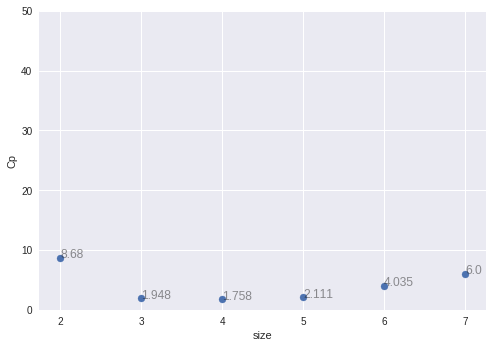

In [32]:
plotting_size_vs_score(scores_cp_df_grpd.index, 
                       scores_cp_df_grpd["Cp"], 
                       annotate=True,
                       ylabel='Cp',
                       ymin=0,
                       ymax=50)

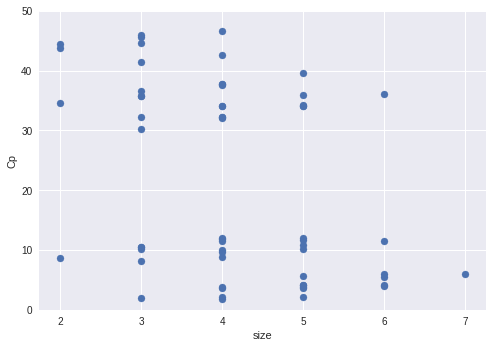

In [33]:
plotting_size_vs_score(scores_cp_df["size"], 
                       scores_cp_df["Cp"], 
                       annotate=False,
                       ylabel='Cp',
                       ymin=0,
                       ymax=50)

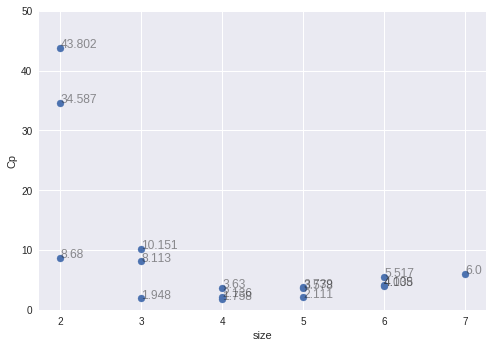

In [34]:
# best 3
best_cp_lst=[]
for i, group in scores_cp_df.groupby("size"):
    best_df = group.sort_values("Cp")
    best_cp_lst.append(best_df.iloc[:3,:])

# plot them
choose_best_cp_df = pd.concat(best_cp_lst)
plotting_size_vs_score(choose_best_cp_df["size"], 
                       choose_best_cp_df["Cp"], 
                       annotate=True,
                       ylabel='Cp',
                       ymin=0,
                       ymax=50)

## Search strategies 

* Given a criterion, we now have to decide how we are going to search through the possible models.

* "Best subset": search all possible models and take the one with highest $R^2_a$ or lowest $C_p$ leaps. Such searches are typically
feasible only up to $p=30$ or $40$ at the very most.

* Stepwise (forward, backward or both): useful when the number of predictors is large. Choose an initial model and be "greedy".

* "Greedy" means always take the biggest jump (up or down) in your selected criterion.

### Implementations in `R`

* "Best subset": use the function `leaps`. Works only for multiple linear regression models.
* Stepwise: use the function `step`. Works for any model with Akaike Information Criterion (AIC). In multiple linear regression, AIC is (almost) a linear function of $C_p$.

### Akaike / Bayes Information Criterion

* Akaike (AIC) defined as $$AIC({\cal M}) = - 2 \log L({\cal M}) + 2 \cdot p({\cal M})$$ where $L({\cal M})$ is the maximized likelihood of the model.
* Bayes (BIC) defined as $$BIC({\cal M}) = - 2 \log L({\cal M}) + \log n \cdot p({\cal M})$$
* Strategy can be used for whenever we have a likelihood, so this generalizes to many statistical models.

### AIC for regression

* In linear regression with unknown $\sigma^2$ $$-2 \log L({\cal M}) = n \log(2\pi \widehat{\sigma}^2_{MLE}) + n$$ where $\widehat{\sigma}^2_{MLE} = \frac{1}{n} SSE(\widehat{\beta})$
* In linear regression with known $\sigma^2$ $$-2 \log L({\cal M}) = n \log(2\pi \sigma^2) + \frac{1}{\sigma^2} SSE(\widehat{\beta})$$ so AIC is very much like Mallow's $C_p$ in this case.


In [35]:
# let's refit the model
election_res = ols('V ~ I + D + W + G:I + P + N', data=election_data).fit()
X = pd.DataFrame(election_res.model.exog, 
                 columns=election_res.model.exog_names)
X.drop(["Intercept"], axis=1).head()

,I,D,W,G:I,P,N
0,1.0,1.0,0.0,2.229,4.252,3.0
1,1.0,0.0,1.0,-11.463,16.535,5.0
2,-1.0,-1.0,0.0,3.872,5.161,10.0
3,-1.0,0.0,0.0,-4.623,0.183,7.0
4,-1.0,-1.0,0.0,14.901,7.069,4.0


In [36]:
print(election_res.model.exog_names)
n = len(election_res.model.exog)
print(election_res.model.exog[:3])

# why plus 1 in k?
# AIC := 2k - 2 * ln(L_hat)
# where k = the number of estimated parameters in the model
# (including the intercept & the variance)
# https://stats.stackexchange.com/questions/87345/calculating-aic-by-hand-in-r

k = len(election_res.model.exog_names) + 1
print("p :", k)
# in linear regression with unknown sigma^2
n * np.log(2 * np.pi * np.sum(election_res.resid**2)/n) + n + 2 * k

['Intercept', 'I', 'D', 'W', 'G:I', 'P', 'N']
[[  1.      1.      1.      0.      2.229   4.252   3.   ]
 [  1.      1.      0.      1.    -11.463  16.535   5.   ]
 [  1.     -1.     -1.      0.      3.872   5.161  10.   ]]
p : 8


-66.94025707214551

AIC result from R
![AIC result from R](./img/12_selection_aic_from_R.png "AIC result from R")

In [37]:
# statsmodels OLS does not yield the same! 
# R notebook reports -66.94025
election_res.aic

-68.94025707214551

In [38]:
# if we say k == 7 (instead of 8)
# then we get AIC == -68.94026
k_2 = 7 # instead of 8
n * np.log(2 * np.pi * np.sum(election_res.resid**2)/n) + n + 2 * k_2

-68.94025707214551

In [39]:
# same estimated parameters between R and statsmodels
election_res.params

Intercept    0.511163
I           -0.020108
D            0.054616
W            0.013391
G:I          0.009690
P           -0.000722
N           -0.005182
dtype: float64

Estimated params from R (Same with statsmodels)
![estimated params from R](./img/12_selection_params.png "estimated params from R")


#### How statsmodels implement AIC and BIC?
In statsmodels.regression.linear_model.RegressionResults


```python
    @cache_readonly
    def aic(self):
        r"""Akaike's information criteria. For a model with a constant
        :math:`-2llf + 2(df\_model + 1)`. For a model without a constant
        :math:`-2llf + 2(df\_model)`."""
        return -2 * self.llf + 2 * (self.df_model + self.k_constant)
        
    @cache_readonly
    def bic(self):
        r"""Bayes' information criteria. For a model with a constant
        :math:`-2llf + \log(n)(df\_model+1)`. For a model without a constant
        :math:`-2llf + \log(n)(df\_model)`"""
        return (-2 * self.llf + np.log(self.nobs) * (self.df_model +
                                                     self.k_constant))

    @property
    def df_model(self):
        """
        The model degree of freedom, defined as the rank of the regressor
        matrix minus 1 if a constant is included.
        """
        if self._df_model is None:
            if self.rank is None:
                self.rank = np.linalg.matrix_rank(self.exog)
            self._df_model = float(self.rank - self.k_constant)
        return self._df_model

    @df_model.setter
    def df_model(self, value):
        self._df_model = value        
        
```

[Source](https://github.com/statsmodels/statsmodels/blob/master/statsmodels/regression/linear_model.py)

In [40]:
print("df_model    :", election_res.df_model)
print("k_constant  :", election_res.k_constant)
print("llf from ols:", election_res.llf) #log-likelihood function
print("llf by hand :", (n * np.log(2 * np.pi * np.sum(election_res.resid**2)/n) + n)/(-2))

df_model    : 6.0
k_constant  : 1
llf from ols: 41.47012853607276
llf by hand : 41.47012853607276


In [41]:
# AIC in statsmodels
# -2 * self.llf + 2 * (self.df_model + self.k_constant)
-2 * election_res.llf + 2 * (election_res.df_model + election_res.k_constant)

-68.94025707214551

#### BIC from statsmodels is also different from R

In [42]:
# BIC in statsmodels
election_res.bic

-61.62860000808155

BIC result from R
![BIC result from R](./img/12_selection_bic_from_R.png "BIC result from R")

In [43]:
# if we say k == 8 (instead of 7)
# then we get BIC == -58.58408
n * np.log(2 * np.pi * np.sum(election_res.resid**2)/n) + n + np.log(n) * k

-58.58407757035813

In [44]:
# else if we say k_2 == 7 (as in statsmodels)
# then we get BIC == -61.62860
n * np.log(2 * np.pi * np.sum(election_res.resid**2)/n) + n + np.log(n) * k_2

-61.62860000808155

### Properties of AIC / BIC

* BIC will typically choose a model as small or smaller than AIC (if using the same search direction).

* As our sample size grows, under some assumptions,
it can be shown that
     - AIC will (asymptotically) always choose a model that contains the true model, i.e. it won't leave any variables out.
     - BIC will (asymptotically) choose exactly the right model.

### Election example

Let's take a look at `step` in action. Probably the simplest
strategy is *forward stepwise* which tries to add one variable at a time, 
as long as it can find a resulting model whose AIC is better than 
its current position. 

When it can make no further additions, it terminates.


**This is not equivalent to R `step`**

R `step`: https://stat.ethz.ch/R-manual/R-devel/library/stats/html/step.html

Q. Does scikit-learn have forward selection/stepwise regression algorithm?

A. (**My favorite answer** by [David Dale](https://datascience.stackexchange.com/users/24162/david-dale))

>Scikit-learn indeed does not support stepwise regression. That's because what is commonly known as 'stepwise regression' is an algorithm based on p-values of coefficients of linear regression, and scikit-learn deliberately avoids inferential approach to model learning (significance testing etc). Moreover, pure OLS is only one of numerous regression algorithms, and from the scikit-learn point of view it is neither very important, nor one of the best.

>There are, however, some pieces of advice for those who still need a good way for feature selection with linear models:

>1. Use inherently sparse models like ElasticNet or Lasso.  
>2. Normalize your features with StandardScaler, and then order your features just by model.coef_. For perfectly independent covariates it is equivalent to sorting by p-values. The class sklearn.feature_selection.RFE will do it for you, and RFECV will even evaluate the optimal number of features. 
>3. Use an [implementation](https://planspace.org/20150423-forward_selection_with_statsmodels/) of forward selection by adjusted R2 that works with statsmodels.  
>4. Do brute-force forward or backward selection to maximize your favorite metric on cross-validation (it could take approximately quadratic time in number of covariates). A scikit-learn compatible mlxtend package [supports](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) this approach for any estimator and any metric.  
>5. If you still want vanilla stepwise regression, it is easier to base it on statsmodels, since this package calculates p-values for you. A basic forward-backward selection could look like this:

```python
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)
```

>This example would print the following output:

```
Add  LSTAT                          with p-value 5.0811e-88
Add  RM                             with p-value 3.47226e-27
Add  PTRATIO                        with p-value 1.64466e-14
Add  DIS                            with p-value 1.66847e-05
Add  NOX                            with p-value 5.48815e-08
Add  CHAS                           with p-value 0.000265473
Add  B                              with p-value 0.000771946
Add  ZN                             with p-value 0.00465162
resulting features:
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN']
```
[Source](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm)

**This is not equivalent to R `step`. In addition, `statsmodels` calculates AIC and BIC differently from R**

In [45]:
# Heavily borrowed from https://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response, criteria):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data
    
    criteria: string, 'AIC' or 'BIC'

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by AIC or BIC
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            if criteria=="AIC":
                score = ols(formula, data).fit().aic
            elif criteria == "BIC":
                score = ols(formula, data).fit().bic   
            else:
                raise Exception("choose between `AIC` and `BIC`")
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            if criteria=="AIC":
                print('Add  {:30} with AIC {:.6}'.format(best_candidate, best_new_score))
            elif criteria=="BIC":
                print('Add  {:30} with BIC {:.6}'.format(best_candidate, best_new_score))
            else:
                raise Exception("choose between `AIC` and `BIC`")
    formula = "{} ~  {}".format(response, ' + '.join(selected))
    model = ols(formula, data).fit()
    return model

In [46]:
fs_model = forward_selected(data=election_data, response='V', criteria='AIC')

Add  D                              with AIC -52.2019
Add  P                              with AIC -52.8212


In [47]:
# The example in R notebook also selected D + P
fs_model.model.formula

'V ~  D + P'

In [48]:
fs_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      V   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     4.579
Date:                Mon, 01 Jul 2019   Prob (F-statistic):             0.0247
Time:                        21:49:36   Log-Likelihood:                 29.411
No. Observations:                  21   AIC:                            -52.82
Df Residuals:                      18   BIC:                            -49.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5140      0.023     22.552      0.000       0.466       0.562
D              0.0431      0.017      2.482      0.023       0.007       0.080
P             -0.0060      0.004     -1.546      0.139      -0.014       0.002
==============================================================================
Omnibus:                        5.270   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.175
Skew:                           0.887   Prob(JB):                        0.204
Kurtosis:                       3.695   Cond. No.                         9.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interactions and hierarchy

We notice that although the *full* model we gave it had the interaction `I:G`, the function `step` never tried to use it. This is 
due to some rules implemented in `step` that do not include an interaction unless both main effects are already in the model. In this case, because neither $I$ nor $G$ were added, the interaction was never considered.

In the `leaps` example, we gave the function the design matrix
and it did not have to consider interactions: they were already encoded in the design matrix.

### BIC example

The only difference between AIC and BIC is the price paid
per variable. This is the argument `k` to `step`. By default `k=2` and for BIC
we set `k=log(n)`. If we set `k=0` it will always add variables.

**This is not equivalent to R `step`. In addition, `statsmodels` calculates AIC and BIC differently from R**

In [49]:
# The example in R notebook also selected D
fs_model = forward_selected(data=election_data, response='V', criteria='BIC')
print(fs_model.model.formula)
fs_model.summary()

Add  D                              with BIC -50.1129
V ~  D


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      V   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     6.305
Date:                Mon, 01 Jul 2019   Prob (F-statistic):             0.0212
Time:                        21:49:36   Log-Likelihood:                 28.101
No. Observations:                  21   AIC:                            -52.20
Df Residuals:                      19   BIC:                            -50.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4864      0.015     33.172      0.000       0.456       0.517
D              0.0451      0.018      2.511      0.021       0.008       0.083
==============================================================================
Omnibus:                        1.375   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                0.626
Skew:                           0.421   Prob(JB):                        0.731
Kurtosis:                       3.083   Cond. No.                         1.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Backward selection

Just for fun, let's consider backwards stepwise. This starts at a full
model and tries to delete variables.

There is also a `direction="both"` option.

**This is not equivalent to R `step`. In addition, `statsmodels` calculates AIC and BIC differently from R**

In [50]:
# Heavily borrowed from https://planspace.org/20150423-forward_selection_with_statsmodels/
def backward_selected(data, response, full_model_formula, criteria):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    full_model_formula: string, for regression model formula
                        e.g. "V ~ I + D + W + G:I + P + N"
    
    criteria: string, 'AIC' or 'BIC'

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by AIC or BIC
    """
    full_model_formula = full_model_formula
    remaining = set([item.strip() for item in full_model_formula.split("~")[1].split("+")])
    removed = []
    
    if criteria=="AIC":
        current_score = ols(full_model_formula, data).fit().aic
    elif criteria=="BIC":
        current_score = ols(full_model_formula, data).fit().bic
    worst_new_score = current_score
    print("initial currents score:", current_score)
    
    while remaining and current_score == worst_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(list(remaining - set(candidate))))
            if criteria=="AIC":
                score = ols(formula, data).fit().aic
            elif criteria == "BIC":
                score = ols(formula, data).fit().bic   
            else:
                raise Exception("choose between `AIC` and `BIC`")
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort(reverse=True)
        worst_new_score, worst_candidate = scores_with_candidates.pop()
        
        if current_score > worst_new_score:
            remaining.remove(worst_candidate)
            removed.append(worst_candidate)
            current_score = worst_new_score
            if criteria=="AIC":
                print('Drop  {:30} with AIC {:.6}'.format(worst_candidate, worst_new_score))
            elif criteria=="BIC":
                print('Drop  {:30} with BIC {:.6}'.format(worst_candidate, worst_new_score))
            else:
                raise Exception("choose between `AIC` and `BIC`")
    
    formula = "{}  ~ {}".format(response, ' + '.join(remaining))
    model = ols(formula, data).fit()
    return model

In [51]:
bs_model = backward_selected(data=election_data, 
                             response='V',
                             full_model_formula="V ~ I + D + W + G:I + P + N", 
                             criteria='AIC')
print(bs_model.model.formula)
bs_model.summary()

initial currents score: -68.94025707214551
Drop  P                              with AIC -70.8915
Drop  W                              with AIC -72.7859
V  ~ N + D + I + G:I


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      V   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     14.89
Date:                Mon, 01 Jul 2019   Prob (F-statistic):           2.95e-05
Time:                        21:49:37   Log-Likelihood:                 41.393
No. Observations:                  21   AIC:                            -72.79
Df Residuals:                      16   BIC:                            -67.56
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5065      0.021     24.483      0.000       0.463       0.550
N             -0.0047      0.003     -1.465      0.162      -0.011       0.002
D              0.0554      0.018      3.049      0.008       0.017       0.094
I             -0.0194      0.015     -1.321      0.205      -0.051       0.012
G:I            0.0096      0.002      6.314      0.000       0.006       0.013
==============================================================================
Omnibus:                        6.866   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                4.547
Skew:                           1.063   Prob(JB):                        0.103
Kurtosis:                       3.825   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**This is not equivalent to R `step`. In addition, `statsmodels` calculates AIC and BIC differently from R**

## Cross-validation

Yet another model selection criterion is 
$K$-fold cross-validation.

- Fix a model ${\cal M}$. Break data set into $K$ approximately equal sized groups $(G_1, \dots, G_K)$.
- For (i in 1:K) Use all groups except $G_i$ to fit model, predict outcome in group $G_i$ based on this model $\widehat{Y}_{j,{\cal M}, G_i}, j \in G_i$.
- Similar to what we saw in Cook's distance / DFFITS.
- Estimate $CV({\cal M}) = \frac{1}{n}\sum_{i=1}^K \sum_{j \in G_i} (Y_j - \widehat{Y}_{j,{\cal M},G_i})^2.$

### Comments about cross-validation.

* It is a general principle that can be used in other situations to "choose parameters."
* Pros (partial list): "objective" measure of a model's predictive power.
* Cons (partial list): all we know about inference is *usually* "out the window" (also true for other model selection procedures).
* If goal is not really inference about certain specific parameters, it is a reasonable way to compare models.

#### glm  
glm is used to fit generalized linear models, specified by giving a symbolic description of the linear predictor and a description of the error distribution.
default family = 'gaussian'  
[Source](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/glm.html)

#### cv.glm  
Cross-Validation For Generalized Linear Models
This function calculates the estimated K-fold cross-validation prediction error for generalized linear models.  
[Source](https://www.rdocumentation.org/packages/boot/versions/1.3-20/topics/cv.glm)

In [52]:
election_glm_res = glm(formula="V ~ Year + I + D + W + G + P + N",
                         data = election_data,
                         family=sm.families.Gaussian()).fit()
election_glm_res.params

Intercept    0.132017
Year         0.000199
I           -0.001962
D            0.051542
W           -0.007197
G           -0.002415
P           -0.007334
N            0.000296
dtype: float64

glm result from R
![glm result from R](./img/12_selection_glm_from_R.png "glm result from R")

##### Using glm from statsmodels and cross validation from scikit-learn
Powerful statsmodels object wrapper  
[Source](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible)

In [53]:
from sklearn.base import BaseEstimator, RegressorMixin

# Heavily borrowed from the Source above
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.family = sm.families.Gaussian()
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X, family=self.family)
        self.results_ = self.model_.fit()
        return (self.model_, self.results_)
        
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [54]:
# check to see if works
sm_wrapper = SMWrapper(sm.GLM)
model, res = sm_wrapper.fit(X = election_glm_res.model.exog,
                           y = election_glm_res.model.endog)

res.params
# same as 
# Intercept    0.132017
# Year         0.000199
# I           -0.001962
# D            0.051542
# W           -0.007197
# G           -0.002415
# P           -0.007334
# N            0.000296

array([ 0.13201656,  0.00019915, -0.00196183,  0.05154232, -0.00719714,
       -0.00241526, -0.00733399,  0.0002965 ])

In [55]:
delta=[]
neg_scores = cross_val_score(estimator = SMWrapper(sm.GLM), 
                X = election_glm_res.model.exog,
                y = election_glm_res.model.endog,
                scoring='neg_mean_squared_error',
               cv=5)

# cross_val_score returns the negated value of the metric!
# Source: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# The actual MSE is simply the positive version
print("5-fold CV: ", np.mean(-1 * neg_scores))
delta.append(np.mean(-1 * neg_scores))

5-fold CV:  0.014052647995457301


In [56]:
# Leave one out Cross Validation
# K == N, the number of samples in the set
neg_scores_loocv = cross_val_score(estimator = SMWrapper(sm.GLM), 
                X = election_res.model.exog,
                y = election_res.model.endog,
                scoring='neg_mean_squared_error',
                cv=(election_data.shape[0]))
print("LOOCV     :", np.mean(-1 * neg_scores_loocv))
delta.append(delta[0] - np.mean(-1 * neg_scores_loocv))

LOOCV     : 0.0023686172803684415


`delta` in cv.glm in R:  

    A vector of length two. The first component is the raw cross-validation estimate of prediction error. The second component is the adjusted cross-validation estimate. The adjustment is designed to compensate for the bias introduced by not using leave-one-out cross-validation.

In [57]:
# cross validation <= random assignments to groups
# can be different 
delta

[0.014052647995457301, 0.01168403071508886]

cv.glm result from R
![cvglm result from R](./img/12_selection_cvglm_from_R.png "cvglm result from R")

### $C_p$ versus 5-fold cross-validation

- Let's plot our $C_p$ versus the $CV$ score.

- Keep in mind that there is additional randomness in the $CV$ score
due to the random assignments to groups. 

In [58]:
election_res = ols('V ~ I + D + W + G:I + P + N', data=election_data).fit()
election_res.model.exog_names.remove("Intercept")
election_res.model.exog_names

['I', 'D', 'W', 'G:I', 'P', 'N']

In [59]:
# heavily borrowed from the Source: https://pypi.org/project/RegscorePy/
def calc_cv_glm(X, y):
    """    
    using sklearn's cross_val_score and 
    statsmodels glm
    """
    neg_scores = cross_val_score(estimator = SMWrapper(sm.GLM), 
                X = X,
                y = y,
                scoring='neg_mean_squared_error',
               cv=5)

    return np.mean(-1 * neg_scores)

In [60]:
# This is not equivalent to R leaps
# modifying the previous one
scores_cp_cv_lst=[]
for r in range(1, len(election_res.model.exog_names)+1):
    comb = combinations(election_res.model.exog_names, r = r)
    
    # y
    y = election_data["V"]
    
    # full model
    formula_full = 'V ~ I + D + W + G:I + P + N'
    election_res_full = ols(formula_full, data=election_data).fit()
    y_pred = election_res_full.predict()    

    for item in comb:
        
        # method='cp' in the R notebook
        formula_subset = 'V ~ {}'.format('+'.join(set(item)))        
        
        # y_sub
        election_res_sub = ols(formula_subset, election_data).fit()
        y_sub = election_res_sub.predict()
        
        # mallow's cp
        cp = calc_mallow_cp(y, y_pred, y_sub, k=6, p=len(set(item)))
        
        # 5-fold cross validation MSE
        cv = calc_cv_glm(X = election_res_sub.model.exog,
                        y = election_res_sub.model.endog)
        
        scores_cp_cv_lst.append((len(item)+1, formula_subset, cp, cv))

In [61]:
scores_cp_cv_df = pd.DataFrame(scores_cp_cv_lst, 
                            columns=["size","formula","Cp", "CV"])
scores_cp_cv_df.head(10)

,size,formula,Cp,CV
0,2,V ~ I,43.802434,0.005457
1,2,V ~ D,34.586822,0.004495
2,2,V ~ W,51.767416,0.008829
3,2,V ~ G:I,8.680026,0.002534
4,2,V ~ P,44.487956,0.005279
5,2,V ~ N,50.834693,0.007433
6,3,V ~ I+D,35.771487,0.004501
7,3,V ~ I+W,41.477029,0.008028
8,3,V ~ I+G:I,8.112744,0.002609
9,3,V ~ I+P,35.695478,0.004454


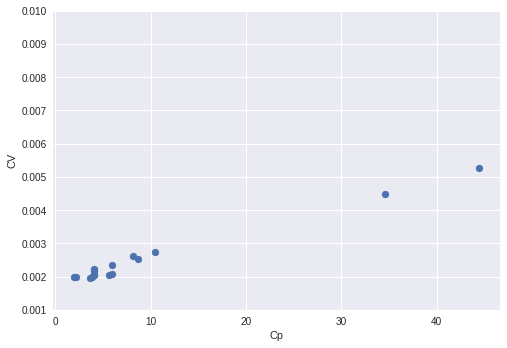

In [62]:
# best 3
best_cp_cv_lst=[]
for i, group in scores_cp_cv_df.groupby("size"):
    best_df = group.sort_values("CV")
    best_cp_cv_lst.append(best_df.iloc[:3,:])

# plot them
choose_best_cp_cv_df = pd.concat(best_cp_cv_lst)
plotting_size_vs_score(choose_best_cp_cv_df["Cp"], 
                       choose_best_cp_cv_df["CV"], 
                       annotate=False,
                       xlabel='Cp',
                       ylabel='CV',
                       ymin=0.001,
                       ymax=0.01)

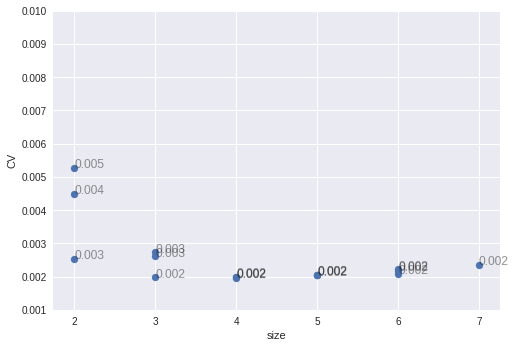

In [63]:
# plot them
choose_best_cp_cv_df = pd.concat(best_cp_cv_lst)
plotting_size_vs_score(choose_best_cp_cv_df["size"], 
                       choose_best_cp_cv_df["CV"], 
                       annotate=True,
                       ylabel='CV',
                       ymin=0.001,
                       ymax=0.01)

## Summarizing results

The model selected depends on the criterion used.

Criterion | Model
--- | ---
$R^2$ | ~ $ I + D + W +G:I + P + N$
$R^2_a$ | ~ $ I + D + P + N$
$C_p$ | ~ $D+P+N$
AIC forward | ~ $D+P$
BIC forward | ~ $D$
AIC backward | ~ $I + D + N + I:G$
5-fold CV | ~ $ I+W$

**The selected model is random and depends on which method we use!**

## Where we are so far

- Many other "criteria" have been proposed.
- Some work well for some types of data, others for different data.
- Check diagnostics!
- These criteria (except cross-validation) are not "direct measures" of predictive power, though Mallow's $C_p$ is a step in this direction.
- $C_p$ measures the quality of a model based on both *bias* and *variance* of the model. Why is this important?
- *Bias-variance* tradeoff is ubiquitous in statistics. More soon.

By the way...

* Stopping stepwise: Why stepwise selection is bad and what you should use instead - by Peter Flom, 09/22/2018 [Source](https://towardsdatascience.com/stopping-stepwise-why-stepwise-selection-is-bad-and-what-you-should-use-instead-90818b3f52df)

* What are some of the problems with stepwise regression? [Source](https://www.stata.com/support/faqs/statistics/stepwise-regression-problems/)